# Janata Hack Computer Vision Modelling using Pytorch



In [1]:
# Importing the essential libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import pandas as pd
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import zipfile as Z
from PIL import Image
import glob
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
import pandas.util.testing as tm

from torchvision.transforms import ToPILImage
from PIL import Image



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Read the training dataset from the zip
with Z.ZipFile('/content/train_SOaYf6m.zip',"r") as z:
    z.extractall()
    with z.open("train.csv") as f:
        train_df = pd.read_csv(f)


In [11]:
print('Shape of training dataset: ', train_df.shape)
train_df.head()


Shape of training dataset:  (1646, 2)


,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


## Sample image

Shape of the image:  (224, 224, 3)


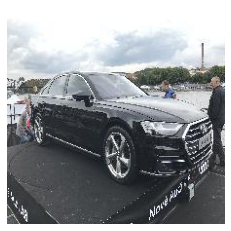

In [4]:

image_list = []

# Source: https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell
for file in glob.glob('/content/images/*.jpg'):
    
    im = Image.open(file)
    image_list.append(mpimg.imread(file))

print('Shape of the image: ', image_list[0].shape)
plt.axis('off')
plt.imshow(image_list[0]);

## Distribution of the target variable in the training dataset



In [5]:
train_df['emergency_or_not'].value_counts()


0    965
1    681
Name: emergency_or_not, dtype: int64

The dataset is a fairly balanced. There are 965 non-emergency vehicles and 681 emergency vehicles.

## Taking a sample of images in both catagories for Visualization


In [6]:
sample_imgs = train_df.groupby('emergency_or_not',as_index = False)[['image_names']].apply(lambda s: s.sample(3)).reset_index()
sample_imgs['image_names']


0    2054.jpg
1    1643.jpg
2    2022.jpg
3     455.jpg
4     487.jpg
5     117.jpg
Name: image_names, dtype: object

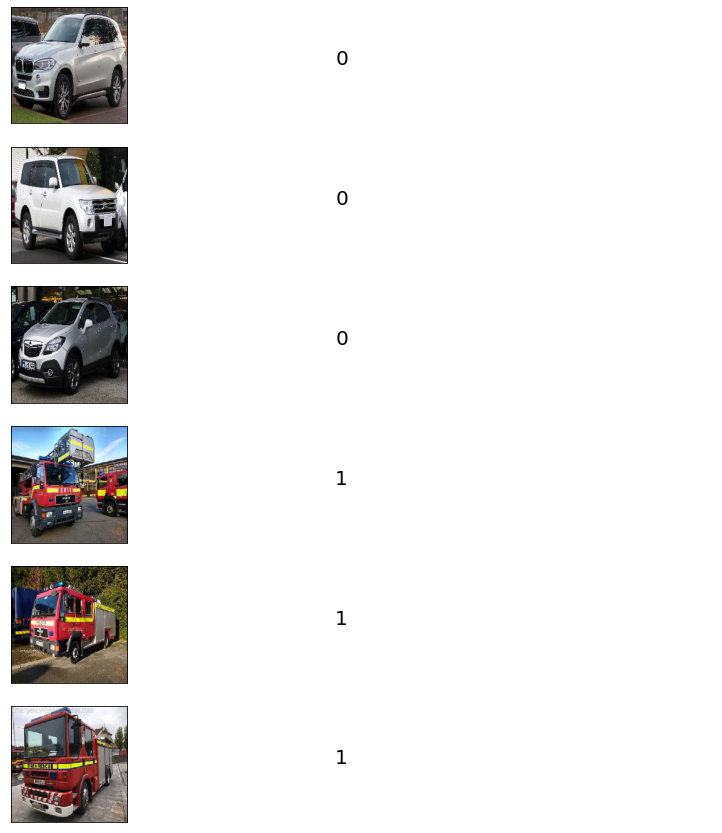

In [7]:
# pytorch provides a function to convert PIL images to tensors.
# Source: https://www.cs.virginia.edu/~vicente/recognition/notebooks/image_processing_lab.html

pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
path = '/content/images'
count = 1
fig = plt.figure(figsize = (15,15))
# Read the image from file. Assuming it is in the same directory.
for img in sample_imgs['image_names']:
  img_path = path + '/' + img
  
  # Open the image from 'images' folder
  pil_image = Image.open(img_path)
  
  # Convert PIL image to torch tensor
  rgb_img = pil2tensor(pil_image)
  
  # Fetch the labels for the sample images from train_df
  target = list(train_df["emergency_or_not"].loc[train_df["image_names"] == img].values)
 

  # Create a subplot grid 
  ax = fig.add_subplot(len(sample_imgs), 2, count, xticks=[], yticks=[] )
  ax.imshow(rgb_img.numpy().transpose(1, 2, 0))

  # increment sub-plot index
  count += 1
   
  ax = fig.add_subplot(len(sample_imgs),2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)

  # Place label by the side of the image
  for i, val in enumerate(target):
    ax.text(0,i,val,fontsize=20)

  # increment sub-plot index
  count += 1


In [8]:
test_df = pd.read_csv('/content/test_vc2kHdQ.csv')
print(test_df.head())
print('Number of observations in test dataset: ', len(test_df))


  image_names
0    1960.jpg
1     668.jpg
2    2082.jpg
3     808.jpg
4    1907.jpg
Number of observations in test dataset:  706


There are 706 test observations in the dataset.

## Creating a custom Dataset function in Pytorch

In [0]:
# Source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class JanataDataset(torch.utils.data.Dataset):

    def __init__(self, df, df_type, root_dir, transform= None):
        """
        Args:
            df : Dataframe
            df_type(string): Type of Dataframe (train, test)
            root_dir(string): directory with all train images
            transform(Optional): Default: None unless passed
        """
        
        self.df = df
        self.df_type = df_type

        if df_type == "train_df":
          self.name_frame = df[['image_names']]
          self.label_frame = df[['emergency_or_not']]
        else:
          self.name_frame = df[['image_names']]

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                     
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        image = plt.imread(img_name,format='RGB')
        image = self.transform(image)

        if self.df_type == 'train_df':
          labels = self.label_frame.iloc[idx, 0]
          labels = torch.tensor(labels)
          sample = image,labels
        else:
          sample = image

        return sample


transform = transforms.Compose([transforms.ToTensor()])  # Other possible transforms include Normalize, Crop

JanataTrainSet = JanataDataset(train_df, df_type = 'train_df', root_dir = '/content/images/', transform = transform)

JanataTestSet = JanataDataset(test_df, df_type = 'test_df', root_dir = '/content/images/', transform = transform)


In [10]:
print(JanataTrainSet[0])

(tensor([[[0.3686, 0.3843, 0.4314,  ..., 0.1020, 0.0902, 0.0549],
         [0.4471, 0.4039, 0.3725,  ..., 0.0863, 0.0902, 0.0745],
         [0.3529, 0.4039, 0.4118,  ..., 0.0667, 0.0824, 0.0824],
         ...,
         [0.3098, 0.3176, 0.3255,  ..., 0.3098, 0.3020, 0.2824],
         [0.2980, 0.3059, 0.3176,  ..., 0.2863, 0.2784, 0.2627],
         [0.3020, 0.3137, 0.3255,  ..., 0.2824, 0.2784, 0.2627]],

        [[0.3765, 0.3922, 0.4353,  ..., 0.2235, 0.2314, 0.2078],
         [0.4549, 0.4118, 0.3765,  ..., 0.1961, 0.2118, 0.2078],
         [0.3608, 0.4118, 0.4157,  ..., 0.1412, 0.1765, 0.1922],
         ...,
         [0.3059, 0.3137, 0.3216,  ..., 0.3059, 0.2980, 0.2784],
         [0.2941, 0.3020, 0.3137,  ..., 0.2824, 0.2745, 0.2588],
         [0.2980, 0.3098, 0.3216,  ..., 0.2784, 0.2745, 0.2588]],

        [[0.2824, 0.3098, 0.3804,  ..., 0.2314, 0.2314, 0.2039],
         [0.3608, 0.3294, 0.3216,  ..., 0.2078, 0.2196, 0.2039],
         [0.2667, 0.3294, 0.3608,  ..., 0.1647, 0.1843, 0

## Splitting data into training and validation set prior loading

In [0]:
val_size = int(0.10*len(JanataTrainSet))
train_size = len(JanataTrainSet) - val_size

train_ds, val_ds = random_split(JanataTrainSet, [train_size, val_size])

## Data Loading process in batches

In [0]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


### A sample from the training set

In [14]:
train_ds[0]

(tensor([[[0.9804, 1.0000, 0.9961,  ..., 0.9961, 0.9882, 0.9882],
          [1.0000, 1.0000, 0.9804,  ..., 0.9961, 0.9961, 0.9882],
          [0.9843, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.5020, 0.5569, 0.4745,  ..., 0.5804, 0.5647, 0.5529],
          [0.5529, 0.5804, 0.5451,  ..., 0.5843, 0.5725, 0.5529],
          [0.6706, 0.5529, 0.6157,  ..., 0.5765, 0.5843, 0.5804]],
 
         [[0.9804, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.4627, 0.5176, 0.4353,  ..., 0.5412, 0.5137, 0.5020],
          [0.5137, 0.5412, 0.5059,  ..., 0.5451, 0.5216, 0.5020],
          [0.6314, 0.5137, 0.5765,  ..., 0.5255, 0.5333, 0.5255]],
 
         [[0.9804, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 1.0000, 1.0000,  ...,

In [15]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    break

tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0])
torch.Size([64, 3, 224, 224])


## Model Definition

In [0]:
num_channels = 3
input_size = num_channels * 224*224
num_classes = 2


In [0]:
class JanataModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 200)
        self.output_layer = nn.Linear(200, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        layer1 = self.input_layer(xb)
        layer1_out = F.relu(layer1)
        out = self.output_layer(layer1_out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = JanataModel()



In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Is the model working?

A sample run to see if the model is working.

In [20]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([64, 2])
Sample outputs :
 tensor([[ 0.1091, -0.0557],
        [ 0.1290, -0.0956]])


In [21]:
for t in model.parameters():
    print(t.shape)

torch.Size([200, 150528])
torch.Size([200])
torch.Size([2, 200])
torch.Size([2])


# Initial accuracy before training

In [22]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.6140046119689941, 'val_loss': 0.6759456992149353}

## Model Fitting

### Fit: 

- Number of epochs = 5
- Learning rate = 1e-5


In [24]:
history = fit(5, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6664, val_acc: 0.7419
Epoch [1], val_loss: 0.6747, val_acc: 0.7159
Epoch [2], val_loss: 0.6653, val_acc: 0.7315
Epoch [3], val_loss: 0.6622, val_acc: 0.7471
Epoch [4], val_loss: 0.6548, val_acc: 0.7315


## Predictions

In [0]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Predicted: 0


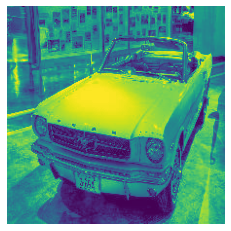

In [26]:
img = JanataTestSet[0]
plt.imshow(img[0])
plt.axis('Off')
print('Predicted:', predict_image(img, model))

Predicted: 1


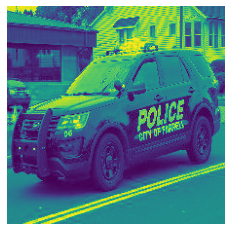

In [27]:
img = JanataTestSet[5]
plt.imshow(img[0])
plt.axis('Off')
print('Predicted:', predict_image(img, model))

Predicted: 1


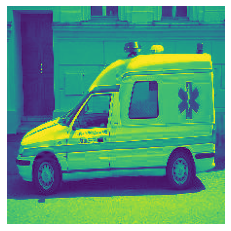

In [33]:
img = JanataTestSet[100]
plt.imshow(img[0])
plt.axis('Off')
print('Predicted:', predict_image(img, model))

In [0]:
# Predictions for all test images
def predictions(data):
  tgt = []
  for i in data:
    preds = predict_image(i, model)
    #print(preds)
    tgt.append(preds)
  return tgt

test_preds = predictions(JanataTestSet)




In [0]:
submission = pd.DataFrame({ 'image_names': test_df['image_names'],
                           'emergency_or_not' : test_preds })

submission.to_csv('submissions.csv', encoding='utf-8', index=False)

In [0]:
# Saving Model
torch.save(model.state_dict(),'/content/sample_data/janata.pth')